In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# Change to corresponding values
dpu_depth = 0
task_depth = 22

dlinear = False
tlinear = True

dpus = [i for i in range(dpu_depth + 1)]
if not dlinear:
    dpus = [1 << i for i in dpus]
    
tasks = [i for i in range(task_depth + 1)]
if not tlinear:
    tasks = [1 << i for i in tasks]


data_file = "../data/out_dpus_{}_tasklets_{}.csv".format(dpu_depth, task_depth)

data = pd.read_csv(data_file)

# Very bad way to subtract the `loop` time from all the other times
nr_dpus = []
nr_tasks = []
dpu_ids = []
task_ids = []
loop_times = []
for nr_dpu in dpus:
    for nr_task in tasks:
        for dpu_id in range(nr_dpu):
            for task_id in range(nr_task):
                nr_dpus.append(nr_dpu)
                nr_tasks.append(nr_task)
                dpu_ids.append(dpu_id)
                task_ids.append(task_id)

                loop_times.append(data.loc[
                    (data["nr_dpu"] == nr_dpu) &
                    (data["nr_tasklet"] == nr_task) & 
                    (data["dpu_id"] == dpu_id) & 
                    (data["tasklet_id"] == task_id) &
                    (data["algorithm"] == "loop") 
                ].iloc[0]["time"])

loop_data = pd.DataFrame.from_dict({"nr_dpu": nr_dpus, "nr_tasklet": nr_tasks, "dpu_id": dpu_ids, "tasklet_id": task_ids, "loop_time": loop_times})
data = data.merge(loop_data, on=["nr_dpu","nr_tasklet","dpu_id","tasklet_id"])

data["clean_time"] = data["time"] - data["loop_time"]

data["bytes_per_sec_per_tasklet"] = (4 * 1e7) / data["time"]
data["bytes_per_sec"] = data["bytes_per_sec_per_tasklet"] * data["nr_tasklet"]

print(data)

      nr_dpu  nr_tasklet  dpu_id  tasklet_id       cycles    time algorithm  \
0          1           1       0           0    330684432   0.945      loop   
1          1           1       0           0    881845056   2.520      xs32   
2          1           1       0           0   3969191376  11.300      mt32   
3          1           1       0           0   3036417072   8.680      sc32   
4          1           1       0           0  11574245552  33.100      lm32   
...      ...         ...     ...         ...          ...     ...       ...   
1260       1          22       0          21    661148656   1.890      loop   
1261       1          22       0          21   1763029792   5.040      xs32   
1262       1          22       0          21   7935423360  22.700      mt32   
1263       1          22       0          21   5960538000  17.000      sc32   
1264       1          22       0          21  22045209264  63.000      lm32   

      loop_time  clean_time  bytes_per_sec_per_task

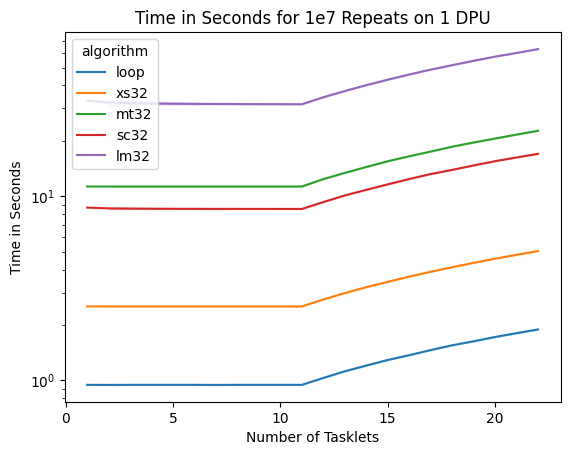

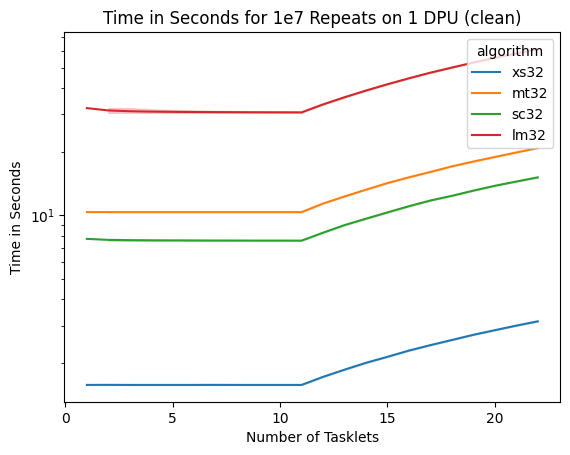

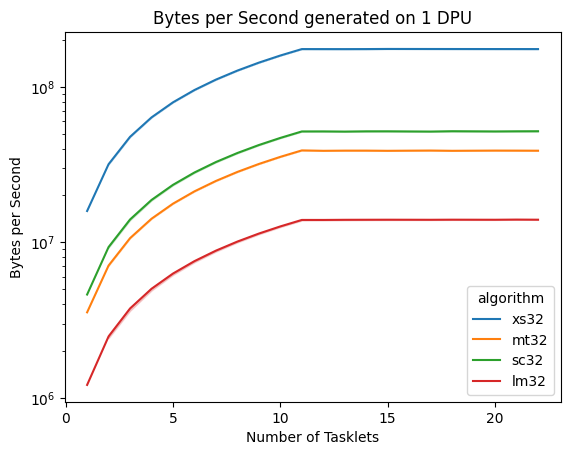

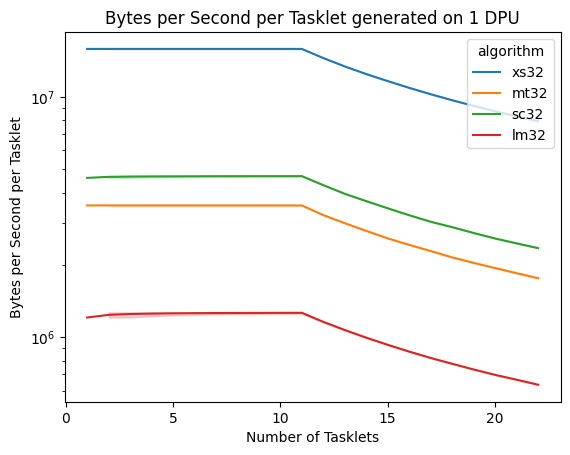

In [34]:
sns.lineplot(data = data, x = "nr_tasklet", y = "time", hue = "algorithm")

plt.yscale("log")

plt.title("Time in Seconds for 1e7 Repeats on 1 DPU")
plt.xlabel("Number of Tasklets")
plt.ylabel("Time in Seconds")

plt.show()


sns.lineplot(data = data[data.algorithm != "loop"], x = "nr_tasklet", y = "clean_time", hue = "algorithm")

plt.yscale("log")

plt.title("Time in Seconds for 1e7 Repeats on 1 DPU (clean)")
plt.xlabel("Number of Tasklets")
plt.ylabel("Time in Seconds")

plt.show()


sns.lineplot(data = data[data.algorithm != "loop"], x = "nr_tasklet", y = "bytes_per_sec", hue = "algorithm")

plt.yscale("log")

plt.title("Bytes per Second generated on 1 DPU")
plt.xlabel("Number of Tasklets")
plt.ylabel("Bytes per Second")

plt.show()


sns.lineplot(data = data[data.algorithm != "loop"], x = "nr_tasklet", y = "bytes_per_sec_per_tasklet", hue = "algorithm")

plt.yscale("log")

plt.title("Bytes per Second per Tasklet generated on 1 DPU")
plt.xlabel("Number of Tasklets")
plt.ylabel("Bytes per Second per Tasklet")

plt.show()